In [17]:
import bindsnet
import numpy as np

# Data Prep

In [26]:
from scipy.io import loadmat

spk_dat=loadmat('/media/maria/DATA1/Documents/NeuroPixelsData/EightNeuroPixelRecordings/spks/spksWaksman_Feb18.mat')

In [48]:
spks=spk_dat['spks'][0][0][0][::-1]-3700
neurons=spk_dat['spks'][0][0][1]
anns=spk_dat['spks'][0][0][2]

In [41]:
anns.shape

(648, 1)

In [66]:
def bin_spikes(spike_times,spike_clusters, anns, bin_size = 10):

    # Using clusters._phy_annotation.npy obtain valid clusters (i.e. >= 2)
    # valid_clusters_idx = np.array(np.where(clusters_annotation>=2))[0]

    spike_time_cells = np.empty(648, dtype=object) # Initalise empty object
    for i in (np.arange(len(np.unique(spike_clusters)))):
      # Create a spike time arrays, where each array in the array is a spike time of a cell
      spike_time_cells[i] = spike_times[(np.where(spike_clusters == i)[0])]

    # Bin spike times into 10ms intervals
    spike_time_binned = np.empty(len(np.unique(spike_clusters)), dtype=object) # Initalise empty object
    sum_spikes = np.empty(len(np.unique(spike_clusters)), dtype=object) # Initalise empty object
    for cell_num in np.arange(1,len(spike_time_cells)):
        spike_time_hist = np.histogram(spike_time_cells[cell_num],bins = np.arange(0,np.floor(spike_time_cells[cell_num][-1]),bin_size))
        spike_time_binned[cell_num] = spike_time_hist[0]
        #sum_spikes[cell_num] = np.sum(spike_time_binned[cell_num])
    #print(spike_time_binned)
    #cell_spikes_max = np.argmax(sum_spikes) # cell with the maximum number of spikes for plotting purposes

    # Spike_time_binned returns binned spikes sorted into cells
    # Spike_time_cells returns UNbinned spikes sorted into cells
    # cell_spikes_max returns a single cell index that has the max number of spikes (i.e most active cell)
    return spike_time_binned

In [67]:
binned=bin_spikes(spks,neurons,anns,0.1)

In [68]:
bn=[]
for j in range(1,len(binned)):
    bn.append(binned[j][:500])

In [70]:
bn=np.array(bn)

In [71]:
bn.shape

(647, 500)

In [72]:
bn=bn.T

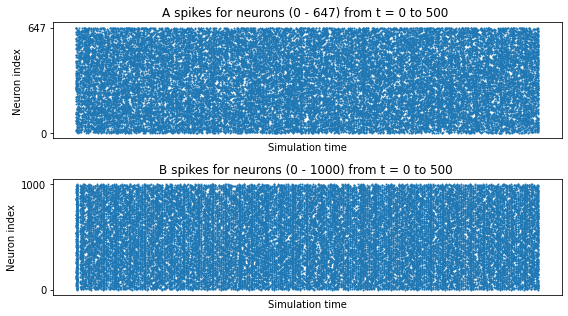

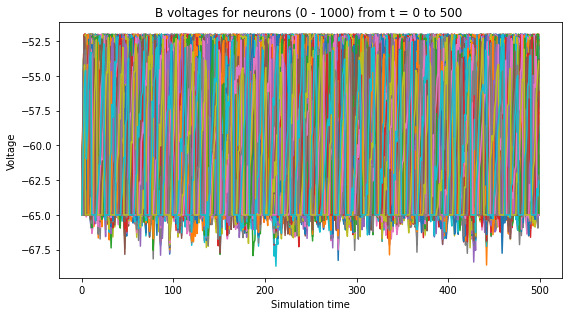

In [73]:
import torch
import matplotlib.pyplot as plt
from bindsnet.network import Network
from bindsnet.network.nodes import Input, LIFNodes
from bindsnet.network.topology import Connection
from bindsnet.network.monitors import Monitor
from bindsnet.analysis.plotting import plot_spikes, plot_voltages

# Simulation time.
time = 500

# Create the network.
network = Network()

# Create and add input, output layers.
source_layer = Input(n=647)
target_layer = LIFNodes(n=1000)

network.add_layer(
    layer=source_layer, name="A"
)
network.add_layer(
    layer=target_layer, name="B"
)

# Create connection between input and output layers.
forward_connection = Connection(
    source=source_layer,
    target=target_layer,
    w=0.05 + 0.1 * torch.randn(source_layer.n, target_layer.n),  # Normal(0.05, 0.01) weights.
)

network.add_connection(
    connection=forward_connection, source="A", target="B"
)

# Create recurrent connection in output layer.
recurrent_connection = Connection(
    source=target_layer,
    target=target_layer,
    w=0.025 * (torch.eye(target_layer.n) - 1), # Small, inhibitory "competitive" weights.
)

network.add_connection(
    connection=recurrent_connection, source="B", target="B"
)

# Create and add input and output layer monitors.
source_monitor = Monitor(
    obj=source_layer,
    state_vars=("s",),  # Record spikes and voltages.
    time=time,  # Length of simulation (if known ahead of time).
)
target_monitor = Monitor(
    obj=target_layer,
    state_vars=("s", "v"),  # Record spikes and voltages.
    time=time,  # Length of simulation (if known ahead of time).
)

network.add_monitor(monitor=source_monitor, name="A")
network.add_monitor(monitor=target_monitor, name="B")

# Create input spike data, where each spike is distributed according to Bernoulli(0.1).
input_data = torch.bernoulli(0.1 * torch.ones(time, source_layer.n)).byte()
inputs = {"A": input_data}

# Simulate network on input data.
network.run(inputs=inputs, time=time)

# Retrieve and plot simulation spike, voltage data from monitors.
spikes = {
    "A": source_monitor.get("s"), "B": target_monitor.get("s")
}
voltages = {"B": target_monitor.get("v")}

plt.ioff()
plot_spikes(spikes)
plot_voltages(voltages, plot_type="line")
plt.show()